<a href="https://www.kaggle.com/code/aravind012/car-price-prediction?scriptVersionId=290675706" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-dataset-from-cardekho/car data.csv
/kaggle/input/vehicle-dataset-from-cardekho/car details v4.csv
/kaggle/input/vehicle-dataset-from-cardekho/CAR DETAILS FROM CAR DEKHO.csv
/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


In [3]:
data = pd.read_csv("/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv").copy()
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
data['name'] = (
    data['name']
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)

BRANDS = [
    'Mercedes-Benz','Land Rover','Ashok Leyland','Maruti','Skoda','Honda',
    'Hyundai','Toyota','Ford','Renault','Mahindra','Tata','Chevrolet','Fiat',
    'Datsun','Jeep','Mitsubishi','Audi','Volkswagen','BMW','Nissan','Lexus',
    'Jaguar','MG','Volvo','Daewoo','Kia','Force','Ambassador','Isuzu',
    'Opel','Peugeot'
]
BRANDS = sorted(BRANDS, key=len, reverse=True)

def split_car_name(name, brands):
    for brand in brands:
        if name.startswith(brand):
            rest = name[len(brand):].strip()
            parts = rest.split()
            return brand, parts[0] if parts else None
    parts = name.split()
    return parts[0], parts[1] if len(parts) > 1 else None

data[['brand', 'model']] = data['name'].apply(
    lambda x: pd.Series(split_car_name(x, BRANDS))
)


In [5]:
data['mileage']   = data['mileage'].str.extract(r'(\d+\.?\d*)').astype(float)
data['engine']    = data['engine'].str.extract(r'(\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract(r'(\d+\.?\d*)').astype(float)

data.drop(columns=['torque', 'name'], inplace=True, errors='ignore')


In [6]:
X = data.drop(columns='selling_price')
y = data['selling_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)


In [7]:
num_features = ['year', 'km_driven', 'mileage', 'engine', 'max_power']
low_card_cat = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']
high_card_cat = ['brand', 'model']


In [8]:
def target_encode_cv(X, y, categorical_cols, n_splits=5, smoothing=10):
    X_encoded = X.copy()
    global_mean = y.mean()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    for col in categorical_cols:
        encoded_col = pd.Series(index=X.index, dtype=float)

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr = y.iloc[train_idx]

            stats = y_tr.groupby(X_tr[col]).agg(['mean', 'count'])
            smooth = (
                (stats['count'] * stats['mean'] + smoothing * global_mean)
                / (stats['count'] + smoothing)
            )

            encoded_col.iloc[val_idx] = X_val[col].map(smooth)

        X_encoded[col + "_te"] = encoded_col.fillna(global_mean)

    return X_encoded

# Train
X_train_te = target_encode_cv(X_train, y_train, high_card_cat)

# Test: map using train statistics
X_test_te = X_test.copy()
global_mean = y_train.mean()
for col in high_card_cat:
    stats = y_train.groupby(X_train[col]).agg(['mean', 'count'])
    smooth = ((stats['count']*stats['mean'] + 10*global_mean)/(stats['count'] + 10))
    X_test_te[col + "_te"] = X_test[col].map(smooth).fillna(global_mean)

# Drop original high-cardinality columns
X_train_te.drop(columns=high_card_cat, inplace=True)
X_test_te.drop(columns=high_card_cat, inplace=True)


In [9]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,
         num_features + [c + "_te" for c in high_card_cat]),
        ("cat", categorical_transformer, low_card_cat)
    ]
)


In [10]:
def log_y(y): return np.log1p(y)
def inv_log_y(y): return np.expm1(y)


In [11]:
models = {
    "Ridge": Ridge(alpha=1.0),

    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE
    ),

    "XGBoost": XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror",
        random_state=RANDOM_STATE, n_jobs=-1
    ),

    "CatBoost": CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=8,
        loss_function="MAE", verbose=0, random_seed=RANDOM_STATE
    )
}


In [12]:
results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_te, log_y(y_train))
    y_pred_log = pipe.predict(X_test_te)
    y_pred = inv_log_y(y_pred_log)
    
    results.append({
        "Model": name,
        "R2_log": r2_score(log_y(y_test), y_pred_log),
        "MAE_price": mean_absolute_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values("MAE_price")
results_df


,Model,R2_log,MAE_price
3,XGBoost,0.939105,66316.960938
1,RandomForest,0.936285,66629.879636
4,CatBoost,0.939099,71597.791817
2,GradientBoosting,0.931696,82407.796900
0,Ridge,0.884770,145066.087798


In [13]:
price_bins = [0, 3e5, 6e5, 1e6, 2e6, np.inf]
labels = ["<3L", "3–6L", "6–10L", "10–20L", "20L+"]

bucket_df = pd.DataFrame({"price": y_test})
bucket_df["bucket"] = pd.cut(bucket_df["price"], bins=price_bins, labels=labels)

best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", best_model)
])
pipe.fit(X_train_te, log_y(y_train))
bucket_df["pred"] = inv_log_y(pipe.predict(X_test_te))

bucket_mae = (
    bucket_df
    .groupby("bucket")
    .apply(lambda x: mean_absolute_error(x["price"], x["pred"]))
    .reset_index(name="MAE")
)
bucket_mae


,bucket,MAE
0,<3L,34830.570312
1,3–6L,57643.359375
2,6–10L,72949.187500
3,10–20L,169494.828125
4,20L+,209702.140625


In [14]:
quantiles = {"P50":0.5, "P90":0.9}
quantile_models = {}
quantile_preds = {}

for name, q in quantiles.items():
    model = GradientBoostingRegressor(
        loss="quantile", alpha=q,
        n_estimators=300, learning_rate=0.05, max_depth=3,
        random_state=RANDOM_STATE
    )
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    pipe.fit(X_train_te, log_y(y_train))
    quantile_preds[name] = inv_log_y(pipe.predict(X_test_te))


In [15]:
bucket_df["P50"] = quantile_preds["P50"]
bucket_df["P90"] = quantile_preds["P90"]

coverage_50 = (bucket_df["price"] <= bucket_df["P50"]).mean()
coverage_90 = (bucket_df["price"] <= bucket_df["P90"]).mean()
coverage_50, coverage_90


(np.float64(0.48031980319803197), np.float64(0.8763837638376384))

In [16]:
brand_eval = X_test.copy()
brand_eval["actual"] = y_test.values
brand_eval["pred"] = bucket_df["pred"].values
brand_eval["abs_error"] = np.abs(brand_eval["actual"] - brand_eval["pred"])
brand_eval["rel_error"] = brand_eval["abs_error"] / brand_eval["actual"]

brand_stats = (
    brand_eval
    .groupby("brand")
    .agg(
        MAE=("abs_error", "mean"),
        Median_Error=("abs_error", "median"),
        Mean_Rel_Error=("rel_error", "mean"),
        Count=("abs_error", "count"),
        Mean_Price=("actual", "mean")
    )
    .sort_values("MAE", ascending=False)
)
brand_stats_filtered = brand_stats[brand_stats["Count"] >= 30]
brand_stats_filtered


,MAE,Median_Error,Mean_Rel_Error,Count,Mean_Price
brand,,,,,
Toyota,126047.203286,69306.000000,0.136996,97,1.001639e+06
Ford,82884.246144,48409.687500,0.168746,77,5.288182e+05
Mahindra,78447.728159,49003.750000,0.148440,137,5.997226e+05
Honda,73464.261958,53596.156250,0.145422,98,5.846530e+05
Renault,64562.052778,44830.687500,0.130331,45,4.830221e+05
Tata,53486.854202,37601.656250,0.189640,148,3.767973e+05
Chevrolet,52850.703993,31878.453125,0.195906,45,2.652444e+05
Volkswagen,49883.280762,42436.062500,0.129694,32,4.196250e+05
Hyundai,45946.594482,37529.218750,0.123514,288,4.410382e+05


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import math

# Helper functions
def log_y(y):  # Log transform for stability
    return np.log1p(y)

def inv_log_y(y_log):  # Inverse transform
    return np.expm1(y_log)

# Collect metrics for all models
metrics_list = []
predictions_dict = {}

for name, model in models.items():
    # Fit model
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    pipe.fit(X_train_te, log_y(y_train))
    
    # Predict
    y_pred_log = pipe.predict(X_test_te)
    y_pred = inv_log_y(y_pred_log)
    
    # Save predictions for later residual plots
    predictions_dict[name] = y_pred
    
    # Compute metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    
    metrics_list.append({
        "Model": name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    })

metrics_df = pd.DataFrame(metrics_list).sort_values("RMSE")
print(metrics_df)

              Model        R2            MAE          RMSE
3           XGBoost  0.975529   66316.960938  1.604049e+10
1      RandomForest  0.973820   66629.879636  1.716089e+10
4          CatBoost  0.963697   71597.791817  2.379626e+10
2  GradientBoosting  0.957769   82407.796900  2.768197e+10
0             Ridge  0.760266  145066.087798  1.571421e+11


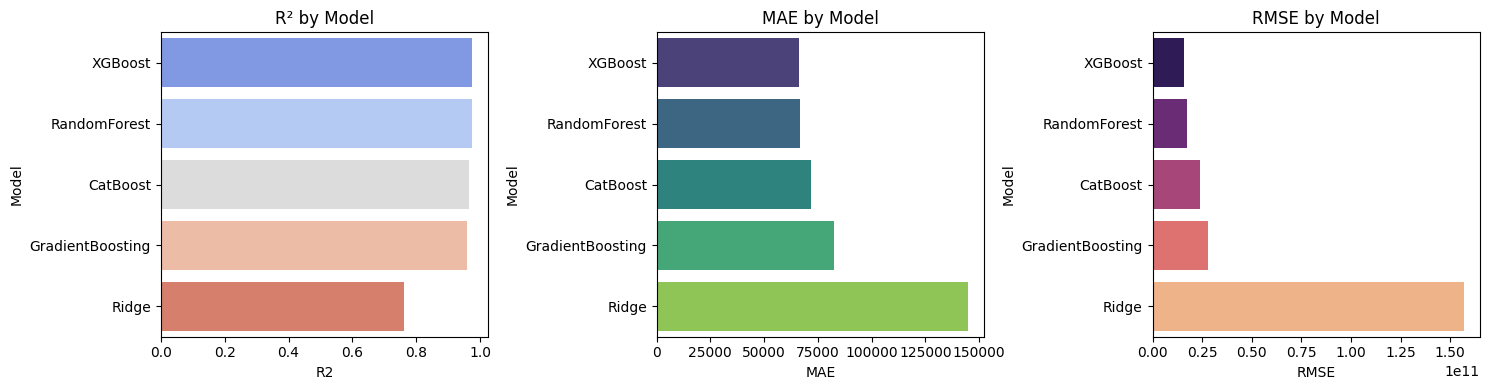

In [18]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.barplot(x="R2", y="Model", data=metrics_df, palette="coolwarm")
plt.title("R² by Model")

plt.subplot(1,3,2)
sns.barplot(x="MAE", y="Model", data=metrics_df, palette="viridis")
plt.title("MAE by Model")

plt.subplot(1,3,3)
sns.barplot(x="RMSE", y="Model", data=metrics_df, palette="magma")
plt.title("RMSE by Model")

plt.tight_layout()
plt.show()

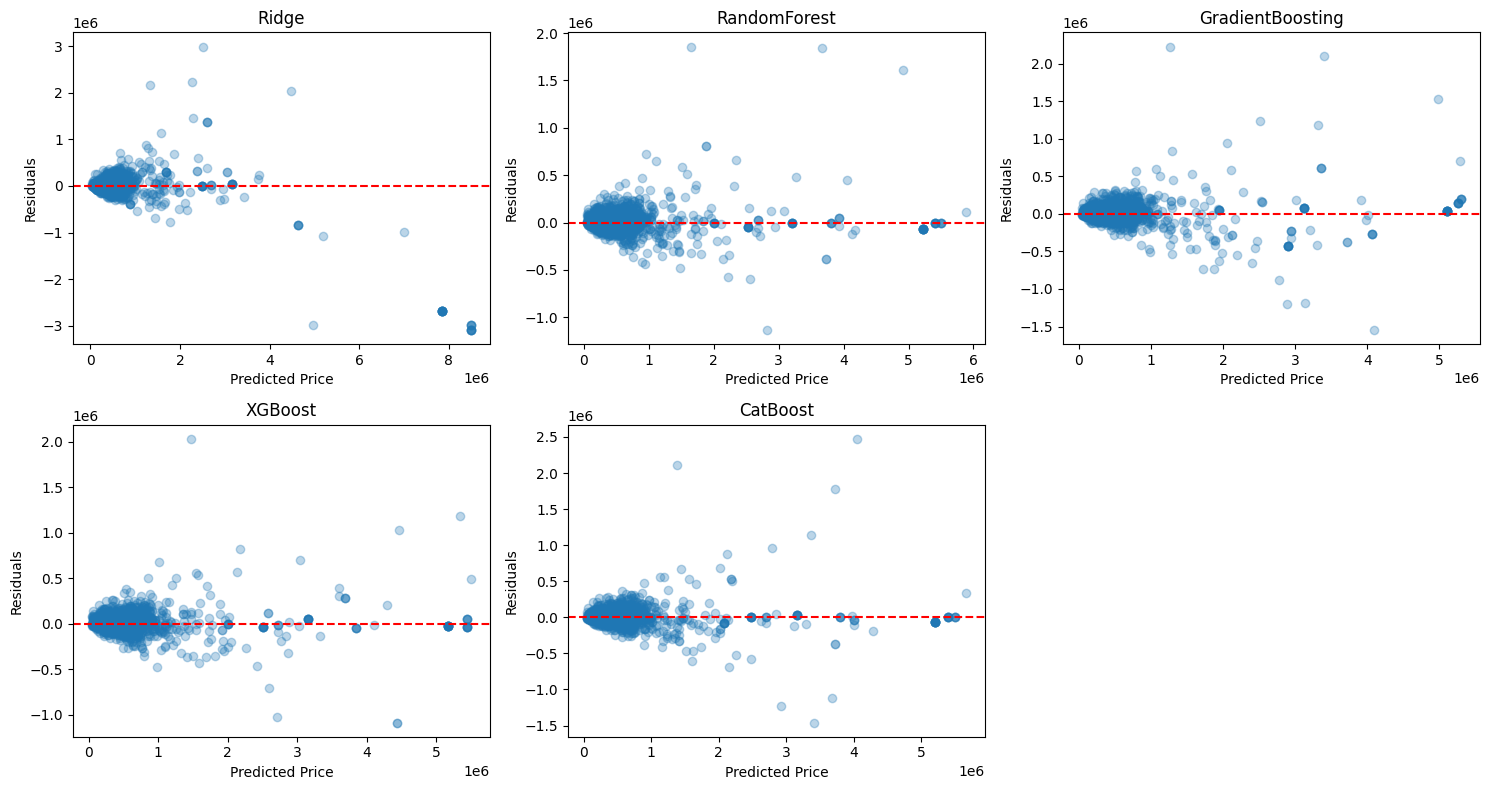

In [19]:
n_models = len(models)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, (name, y_pred) in enumerate(predictions_dict.items()):
    residuals = y_test - y_pred
    
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(name)
    plt.xlabel("Predicted Price")
    plt.ylabel("Residuals")

plt.tight_layout()
plt.show()